In [1]:
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
from sklearn.datasets import make_moons


In [2]:
class Flow(nn.Sequential):
    """docstring for Flow"""

    def __init__(
        self,
        in_dim: int = 2,
        hidden_dim: int = 64,
        num_layers: int = 4,
    ) -> None:
        layers = []
        prev_dim = in_dim + 1
        for _ in range(num_layers - 1):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ELU(),
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, in_dim))
        super(Flow, self).__init__(*layers)

    def forward(self, inputs: Tensor, t: Tensor) -> Tensor:
        """
        Parameters
        ----------
        inputs : Tensor[size=(..., in_dim), dtype=float]
        t : Tensor[size=(...), dtype=float]

        Returns
        -------
        outputs : Tensor[size=(..., in_dim), dtype=float]
        """
        return super().forward(torch.cat([inputs, t.unsqueeze(-1)], dim=-1))

    def step(self, inputs: Tensor, t_start: Tensor, t_stop: Tensor) -> Tensor:
        """
        Parameters
        ----------
        inputs : Tensor[size=(..., in_dim), dtype=float]
        t_start : Tensor[size=(...), dtype=float]
        t_stop : Tensor[size=(...), dtype=float]

        Returns
        -------
        outputs : Tensor[size=(..., in_dim), dtype=float]
        """
        t = t_stop - t_start
        yt_half = inputs + t.unsqueeze(-1)/2 * self.forward(inputs, t=t_start)
        return inputs + t.unsqueeze(-1) * self.forward(yt_half, t=t_start + t/2)


Start training (10000 epochs)
[ 1000/10000] loss = 1.0807, lapsed = 3.11 s
[ 2000/10000] loss = 1.0165, lapsed = 3.12 s
[ 3000/10000] loss = 0.9696, lapsed = 3.04 s
[ 4000/10000] loss = 0.9812, lapsed = 3.08 s
[ 5000/10000] loss = 1.0436, lapsed = 3.10 s
[ 6000/10000] loss = 0.9654, lapsed = 3.18 s
[ 7000/10000] loss = 0.9001, lapsed = 3.12 s
[ 8000/10000] loss = 0.9454, lapsed = 3.18 s
[ 9000/10000] loss = 0.9414, lapsed = 3.46 s
[10000/10000] loss = 0.8729, lapsed = 3.04 s


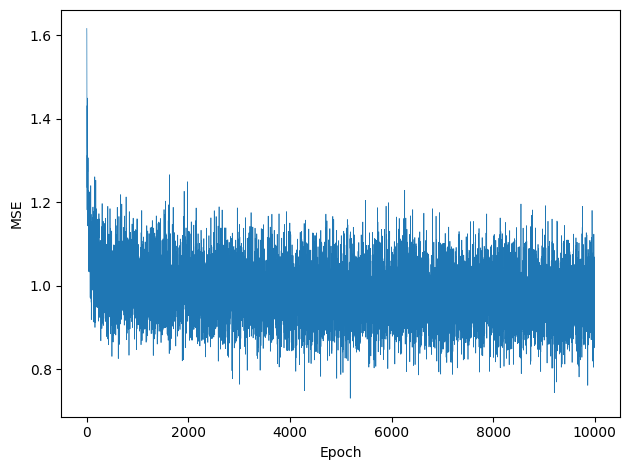

In [5]:
num_epochs = 10000
n_samples = 256
lr = 1e-2
device = 'mps'
verb_freq = 1000

flow = Flow()
flow.to(device)

optim = torch.optim.Adam(flow.parameters(), lr=lr)
loss_fn = nn.MSELoss()
loss_fn.to(device)

loss_hist = []
print(f'Start training ({num_epochs} epochs)')
start = time.time()
for epoch_idx in range(1, num_epochs+1):
    x, y = make_moons(n_samples, noise=0.05)
    x_1 = torch.from_numpy(x).to(dtype=torch.float32, device=device)
    x_0 = torch.randn_like(x_1)
    t = torch.rand((n_samples, 1), device=device)

    x_t = (1-t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    est = flow(x_t, t.squeeze(1))
    loss = loss_fn(est, dx_t)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_hist.append(loss.detach().item())

    if epoch_idx % verb_freq == 0:
        stop, start = start, time.time()
        lapsed = start - stop
        print(f'[{epoch_idx:5d}/{num_epochs}] loss = {loss.detach().item():.4f}, lapsed = {lapsed:.2f} s')

with plt.style.context({
    'lines.linewidth': 0.5,
}):
    f_loss, a_loss = plt.subplots(tight_layout=True)
    a_loss.plot(loss_hist)
    a_loss.set(xlabel='Epoch', ylabel='MSE')

plt.show()


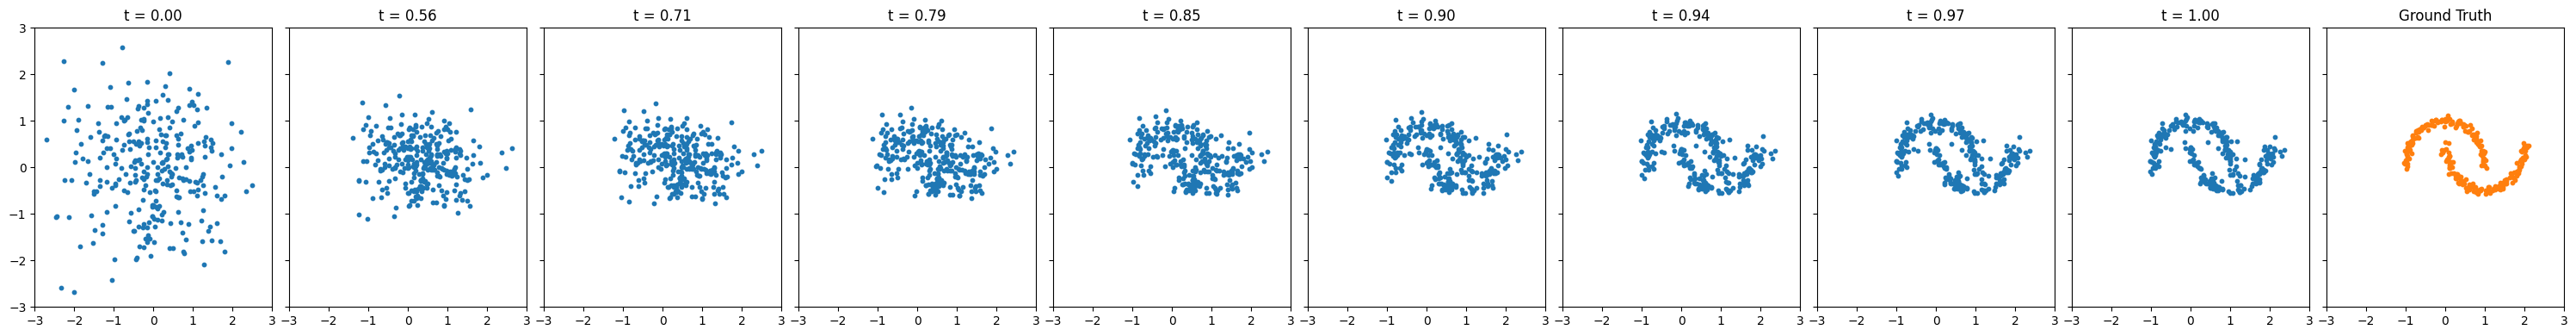

In [20]:
x = torch.randn(300, 2).to(device)
n_steps = 8

f_sampling, a_sampling = plt.subplots(1, n_steps + 2, sharex=True, sharey=True, tight_layout=True,
                                      figsize=(30, 4))
time_steps = torch.linspace(0, 1, n_steps + 1).unsqueeze(1).expand((n_steps+1, x.size(0))).to(device)
time_steps = (torch.log10(torch.linspace(1, 100, n_steps+1)) / 2).unsqueeze(1).expand((n_steps+1, x.size(0))).to(device)

with torch.no_grad():
    a_sampling[0].scatter(*x.cpu().t(), s=10)
    a_sampling[0].set(
        title=f't = {time_steps[0, 0].item():.2f}',
        xlim=[-3.0, 3.0],
        ylim=[-3.0, 3.0],
    )

    for t_start, t_end, ax_i in zip(time_steps[:-1], time_steps[1:], a_sampling[1:-1]):
        x = flow.step(x, t_start=t_start, t_stop=t_end)
        ax_i.scatter(*x.cpu().t(), s=10)
        ax_i.set_title(f't = {t_end[0].item():.2f}')

    x_gt, _ = make_moons(n_samples, noise=0.05)
    a_sampling[-1].scatter(*x_gt.T, s=10, c='C1')
    a_sampling[-1].set_title('Ground Truth')

plt.show()
